### Data Dictionary

In this exercise, you will copy an existing training experiment from the Azure AI Gallery and run it to train a classification model that predicts whether or not Rosie will make a profit on a given day.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump,load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Data Exploration

In [2]:
df = pd.read_csv("Profitability.csv")

In [3]:
df

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Profitable
0,01/01/2017,Sunday,27.0,2.00,15,0.3,10,0
1,02/01/2017,Monday,28.9,1.33,15,0.3,13,0
2,03/01/2017,Tuesday,34.5,1.33,27,0.3,15,0
3,04/01/2017,Wednesday,44.1,1.05,28,0.3,17,0
4,05/01/2017,Thursday,42.4,1.00,33,0.3,18,0
...,...,...,...,...,...,...,...,...
360,27/12/2017,Wednesday,42.7,1.00,33,0.3,19,0
361,28/12/2017,Thursday,37.8,1.25,32,0.3,16,0
362,29/12/2017,Friday,39.5,1.25,17,0.3,15,0
363,30/12/2017,Saturday,30.9,1.43,22,0.3,13,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         365 non-null    object 
 1   Day          365 non-null    object 
 2   Temperature  365 non-null    float64
 3   Rainfall     365 non-null    float64
 4   Flyers       365 non-null    int64  
 5   Price        365 non-null    float64
 6   Sales        365 non-null    int64  
 7   Profitable   365 non-null    int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 22.9+ KB


In [5]:
df.describe(include='all')

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales,Profitable
count,365,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
unique,365,7,NaN,NaN,NaN,NaN,NaN,NaN
top,10/05/2017,Sunday,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,53,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,60.731233,0.826603,40.284932,0.333973,25.323288,0.482192
std,NaN,NaN,16.196266,0.273171,13.178651,0.075206,6.893589,0.500369
min,NaN,NaN,15.100000,0.470000,9.000000,0.300000,7.000000,0.000000
25%,NaN,NaN,49.700000,0.650000,31.000000,0.300000,20.000000,0.000000
50%,NaN,NaN,61.100000,0.740000,39.000000,0.300000,25.000000,0.000000
75%,NaN,NaN,71.300000,0.910000,49.000000,0.300000,30.000000,1.000000


In [6]:
df.shape

(365, 8)

In [7]:
df.columns

Index(['Date', 'Day', 'Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales',
       'Profitable'],
      dtype='object')

### Data Visualization

### Univariate Data Exploration

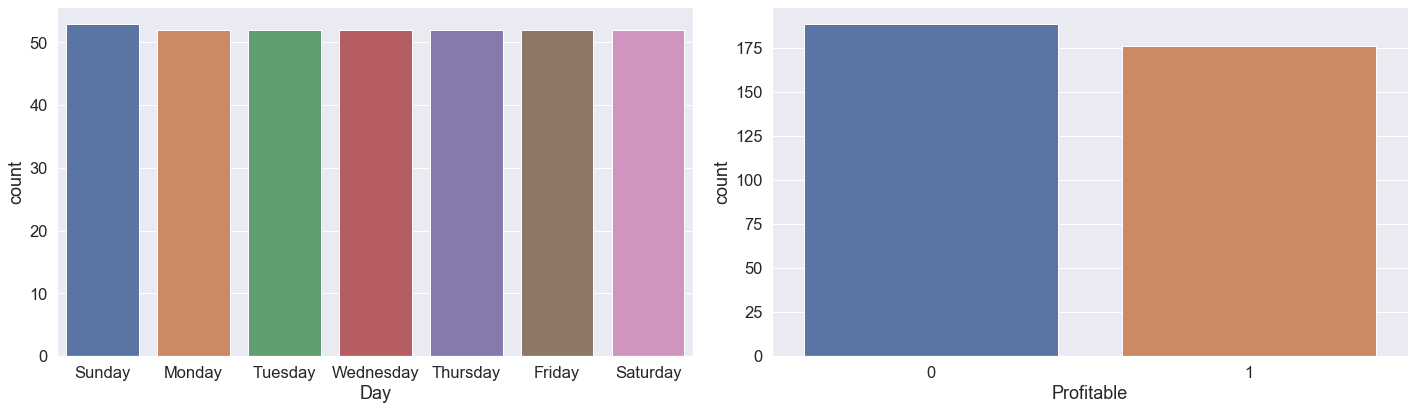

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.Day)
plt.subplot(7,2,2)
sns.countplot(df.Profitable)
# plt.subplot(7,2,3)
# sns.countplot()
# plt.subplot(7,2,4)
# sns.countplot()
# plt.subplot(7,2,5)
# sns.countplot()
# plt.subplot(7,2,6)
# sns.countplot()
# plt.subplot(7,2,7)
# sns.countplot()
# plt.subplot(7,2,8)
# sns.countplot()
# plt.subplot(7,2,9)
# sns.countplot()
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [9]:
df.corr()

,Temperature,Rainfall,Flyers,Price,Sales,Profitable
Temperature,1.000000,-0.902859,0.797719,0.504709,0.989832,0.779351
Rainfall,-0.902859,1.000000,-0.747389,-0.383775,-0.909214,-0.671347
Flyers,0.797719,-0.747389,1.000000,0.405437,0.805183,0.637363
Price,0.504709,-0.383775,0.405437,1.000000,0.512908,0.468758
Sales,0.989832,-0.909214,0.805183,0.512908,1.000000,0.790167
Profitable,0.779351,-0.671347,0.637363,0.468758,0.790167,1.000000


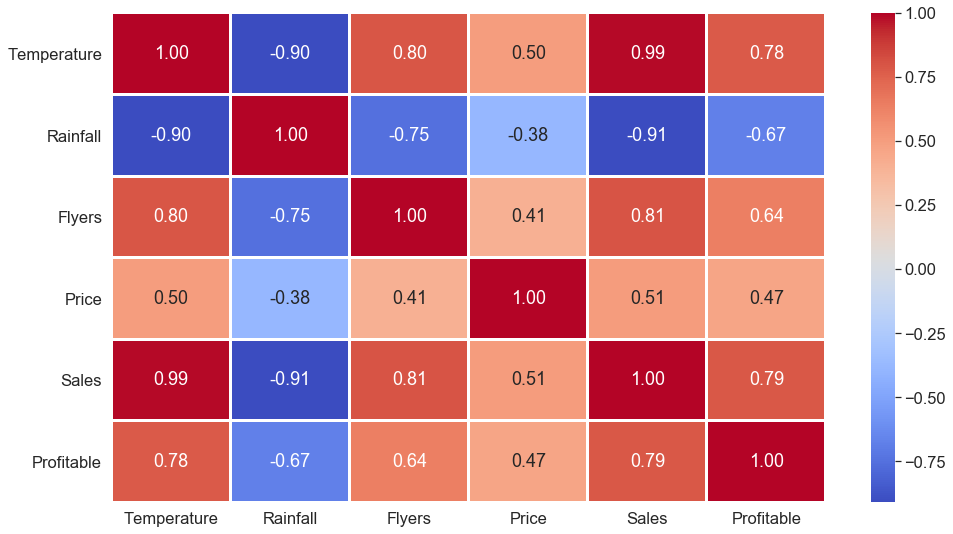

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

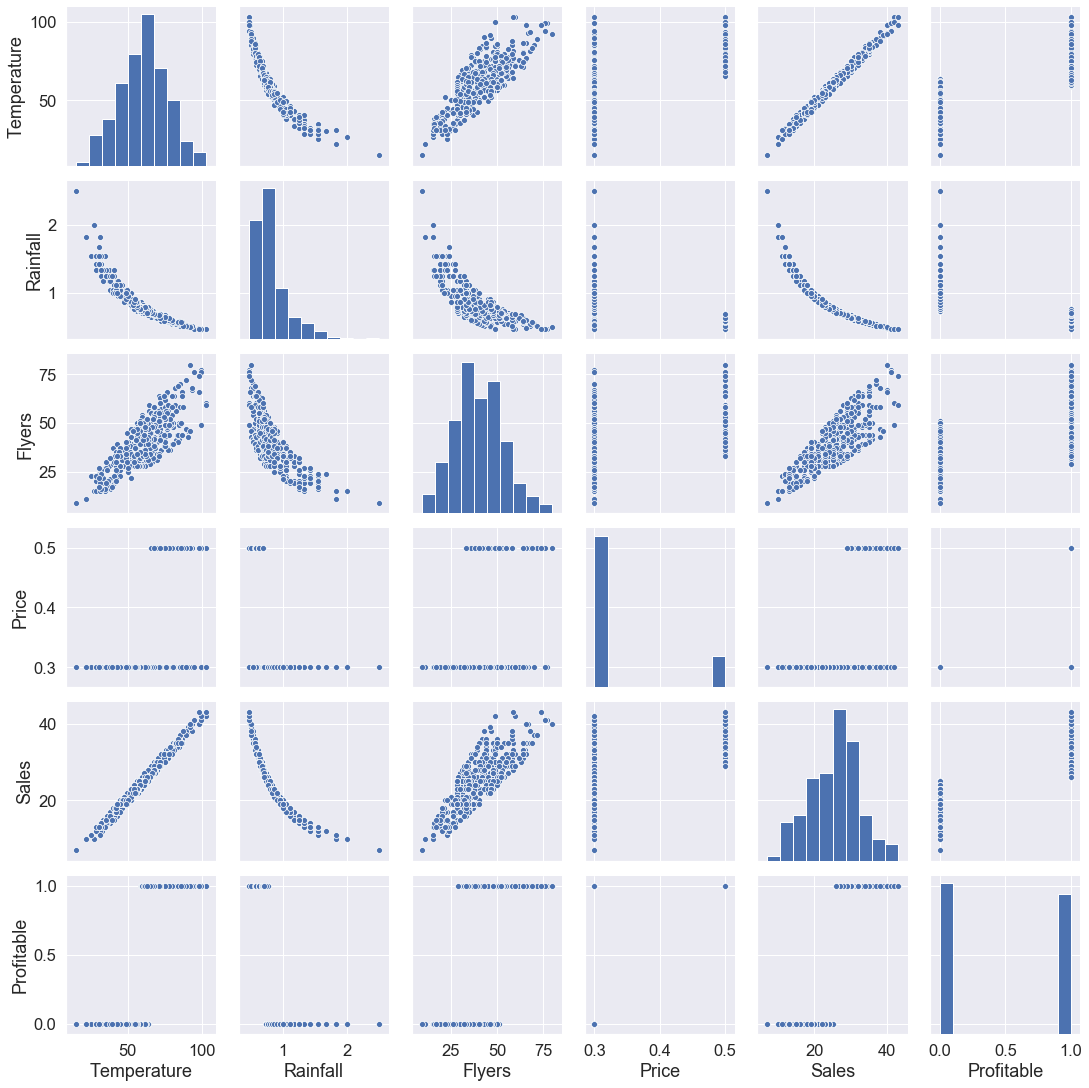

In [11]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

Date           0
Day            0
Temperature    0
Rainfall       0
Flyers         0
Price          0
Sales          0
Profitable     0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

### Treat Data Types

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         365 non-null    object 
 1   Day          365 non-null    object 
 2   Temperature  365 non-null    float64
 3   Rainfall     365 non-null    float64
 4   Flyers       365 non-null    int64  
 5   Price        365 non-null    float64
 6   Sales        365 non-null    int64  
 7   Profitable   365 non-null    int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 22.9+ KB


In [15]:
df2 = pd.get_dummies(df,columns=['Day'],drop_first=True)

In [16]:
df2

,Date,Temperature,Rainfall,Flyers,Price,Sales,Profitable,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,01/01/2017,27.0,2.00,15,0.3,10,0,0,0,1,0,0,0
1,02/01/2017,28.9,1.33,15,0.3,13,0,1,0,0,0,0,0
2,03/01/2017,34.5,1.33,27,0.3,15,0,0,0,0,0,1,0
3,04/01/2017,44.1,1.05,28,0.3,17,0,0,0,0,0,0,1
4,05/01/2017,42.4,1.00,33,0.3,18,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27/12/2017,42.7,1.00,33,0.3,19,0,0,0,0,0,0,1
361,28/12/2017,37.8,1.25,32,0.3,16,0,0,0,0,1,0,0
362,29/12/2017,39.5,1.25,17,0.3,15,0,0,0,0,0,0,0
363,30/12/2017,30.9,1.43,22,0.3,13,0,0,1,0,0,0,0


### Drop unwanted features

In [17]:
df2.columns

Index(['Date', 'Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales',
       'Profitable', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [18]:
df2.drop(['Date'],axis=1,inplace=True)

In [19]:
df2

,Temperature,Rainfall,Flyers,Price,Sales,Profitable,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,27.0,2.00,15,0.3,10,0,0,0,1,0,0,0
1,28.9,1.33,15,0.3,13,0,1,0,0,0,0,0
2,34.5,1.33,27,0.3,15,0,0,0,0,0,1,0
3,44.1,1.05,28,0.3,17,0,0,0,0,0,0,1
4,42.4,1.00,33,0.3,18,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
360,42.7,1.00,33,0.3,19,0,0,0,0,0,0,1
361,37.8,1.25,32,0.3,16,0,0,0,0,1,0,0
362,39.5,1.25,17,0.3,15,0,0,0,0,0,0,0
363,30.9,1.43,22,0.3,13,0,0,1,0,0,0,0


In [20]:
df2 = df2[['Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales','Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'Profitable']]

In [21]:
df2

,Temperature,Rainfall,Flyers,Price,Sales,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Profitable
0,27.0,2.00,15,0.3,10,0,0,1,0,0,0,0
1,28.9,1.33,15,0.3,13,1,0,0,0,0,0,0
2,34.5,1.33,27,0.3,15,0,0,0,0,1,0,0
3,44.1,1.05,28,0.3,17,0,0,0,0,0,1,0
4,42.4,1.00,33,0.3,18,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
360,42.7,1.00,33,0.3,19,0,0,0,0,0,1,0
361,37.8,1.25,32,0.3,16,0,0,0,1,0,0,0
362,39.5,1.25,17,0.3,15,0,0,0,0,0,0,0
363,30.9,1.43,22,0.3,13,0,1,0,0,0,0,0


### Create and save processed dataset

In [22]:
#df2.to_csv("classlemon.csv",index=False)

In [23]:
df2.shape

(365, 12)

### Train Test Split

In [24]:
X = df2.iloc[:,0:11]
y = df2.iloc[:,11]

In [25]:
X.values, y.values

(array([[27.  ,  2.  , 15.  , ...,  0.  ,  0.  ,  0.  ],
        [28.9 ,  1.33, 15.  , ...,  0.  ,  0.  ,  0.  ],
        [34.5 ,  1.33, 27.  , ...,  0.  ,  1.  ,  0.  ],
        ...,
        [39.5 ,  1.25, 17.  , ...,  0.  ,  0.  ,  0.  ],
        [30.9 ,  1.43, 22.  , ...,  0.  ,  0.  ,  0.  ],
        [15.1 ,  2.5 ,  9.  , ...,  0.  ,  0.  ,  0.  ]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

### Treat Imbalance Data

In [26]:
y.value_counts()

0    189
1    176
Name: Profitable, dtype: int64

In [27]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [28]:
new_X, new_y = ros.fit_resample(X, y)

In [29]:
new_y.value_counts()

1    189
0    189
Name: Profitable, dtype: int64

In [30]:
new_X

,Temperature,Rainfall,Flyers,Price,Sales,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,27.0,2.00,15,0.3,10,0,0,1,0,0,0
1,28.9,1.33,15,0.3,13,1,0,0,0,0,0
2,34.5,1.33,27,0.3,15,0,0,0,0,1,0
3,44.1,1.05,28,0.3,17,0,0,0,0,0,1
4,42.4,1.00,33,0.3,18,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
373,73.6,0.63,55,0.5,32,0,0,0,0,0,1
374,72.6,0.59,60,0.3,32,0,0,1,0,0,0
375,91.7,0.51,46,0.5,39,0,0,0,1,0,0
376,65.7,0.65,45,0.5,29,0,0,1,0,0,0


In [31]:
new_X.values, new_y.values

(array([[27.  ,  2.  , 15.  , ...,  0.  ,  0.  ,  0.  ],
        [28.9 ,  1.33, 15.  , ...,  0.  ,  0.  ,  0.  ],
        [34.5 ,  1.33, 27.  , ...,  0.  ,  1.  ,  0.  ],
        ...,
        [91.7 ,  0.51, 46.  , ...,  1.  ,  0.  ,  0.  ],
        [65.7 ,  0.65, 45.  , ...,  0.  ,  0.  ,  0.  ],
        [84.2 ,  0.56, 44.  , ...,  0.  ,  1.  ,  0.  ]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [32]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((302, 11), (76, 11), (302,), (76,))

### Feature Scaling

In [34]:
X_train

array([[38.1 ,  1.18, 20.  , ...,  0.  ,  0.  ,  0.  ],
       [79.9 ,  0.61, 39.  , ...,  0.  ,  0.  ,  0.  ],
       [84.2 ,  0.56, 44.  , ...,  0.  ,  1.  ,  0.  ],
       ...,
       [58.8 ,  0.74, 32.  , ...,  0.  ,  0.  ,  0.  ],
       [40.4 ,  1.  , 29.  , ...,  0.  ,  0.  ,  0.  ],
       [72.3 ,  0.65, 36.  , ...,  1.  ,  0.  ,  0.  ]])

In [35]:
minmax = MinMaxScaler()

In [36]:
X_train_scaled = minmax.fit_transform(X_train)

In [37]:
X_test_scaled = minmax.transform(X_test)

In [38]:
X_train_scaled

array([[0.261959  , 0.34975369, 0.15492958, ..., 0.        , 0.        ,
        0.        ],
       [0.738041  , 0.06896552, 0.42253521, ..., 0.        , 0.        ,
        0.        ],
       [0.78701595, 0.04433498, 0.49295775, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.4977221 , 0.13300493, 0.32394366, ..., 0.        , 0.        ,
        0.        ],
       [0.2881549 , 0.26108374, 0.28169014, ..., 0.        , 0.        ,
        0.        ],
       [0.65148064, 0.08866995, 0.38028169, ..., 1.        , 0.        ,
        0.        ]])

In [39]:
X_test_scaled

array([[0.64806378, 0.09852217, 0.76056338, 0.        , 0.63888889,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.72323462, 0.0591133 , 0.38028169, 0.        , 0.69444444,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.4498861 , 0.19704433, 0.26760563, 0.        , 0.41666667,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.6332574 , 0.09852217, 0.5915493 , 0.        , 0.61111111,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.62870159, 0.08866995, 0.66197183, 1.        , 0.66666667,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.49088838, 0.14778325, 0.33802817, 0.        , 0.47222222,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.2095672 , 0.34975369, 0.14084507, 0.        , 0.

### Model Training

### Using XGBoost (Scikit-Learn)

In [40]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [41]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0
[2]	validation_0-error:0
[3]	validation_0-error:0
[4]	validation_0-error:0
[5]	validation_0-error:0
[6]	validation_0-error:0
[7]	validation_0-error:0
[8]	validation_0-error:0
[9]	validation_0-error:0
[10]	validation_0-error:0
Stopping. Best iteration:
[0]	validation_0-error:0



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
y_pred = xgbmodel.predict(X_test_scaled)

In [43]:
y_pred

array([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0], dtype=int64)

### Model Evaluation

In [44]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[39,  0],
       [ 0, 37]], dtype=int64)

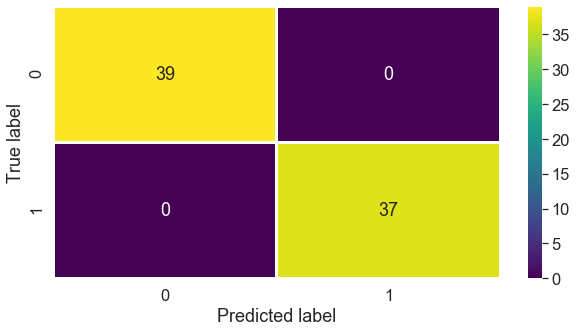

In [45]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

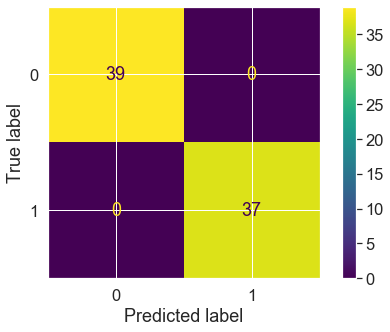

In [46]:
fig , ax = plt.subplots(figsize=(8,5))
plot_confusion_matrix(xgbmodel,X_test_scaled,y_test,values_format='.4g',ax=ax)
plt.show()

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        37

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



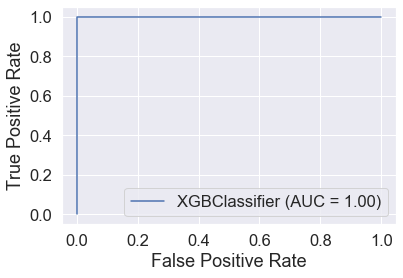

In [48]:
plot_roc_curve(xgbmodel,X_test_scaled,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [49]:
X.columns

Index(['Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales', 'Day_Monday',
       'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday',
       'Day_Wednesday'],
      dtype='object')

In [50]:
xgbmodel.get_booster().feature_names = ['Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales', 'Day_Monday',
       'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday',
       'Day_Wednesday']

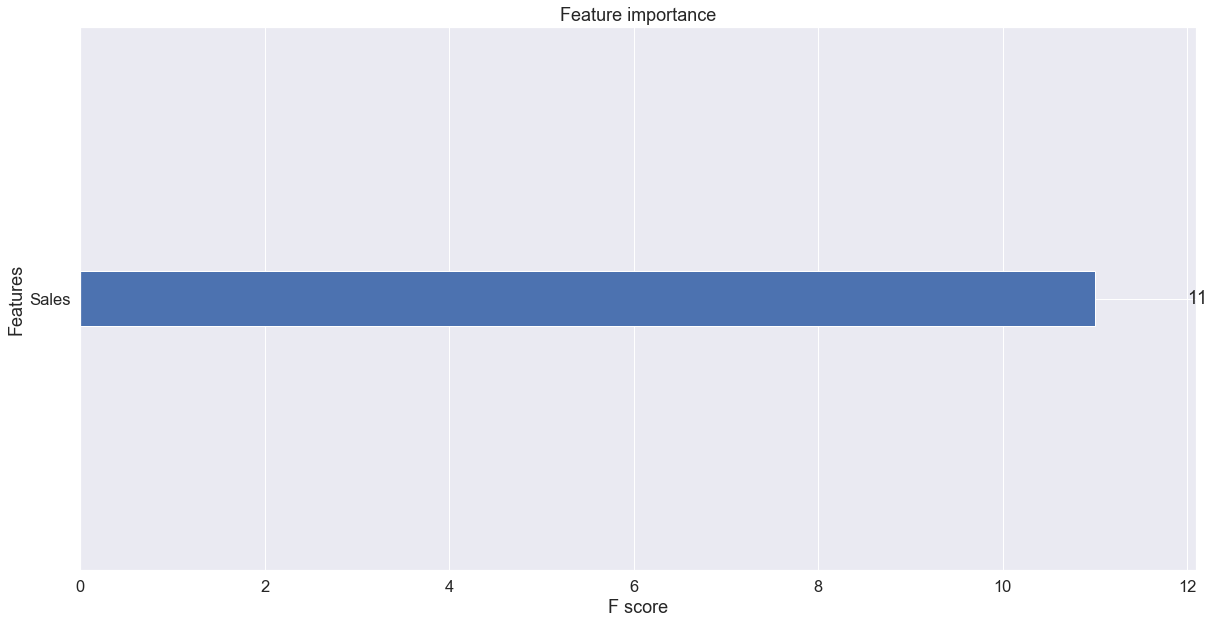

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

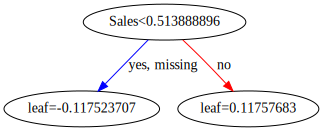

In [52]:
xgb.to_graphviz(xgbmodel,num_trees=10)

### Cross-Validation

In [53]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [54]:
cv.mean()

1.0

### Save the Model

In [55]:
filename = 'modelclasslemon.sav'
dump(xgbmodel,open(filename,'wb'))